<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D1_CNN1_A3_testAugment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input


In [3]:
from google.colab import drive

drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Dataset/Dataset2/crop_part1.zip'

Streaming output truncated to the last 5000 lines.
  inflating: crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104204327523.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105164106036.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105172720493.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170108224608753.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170109140259136.jpg.

In [4]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

In [5]:
# Define augmentation functions
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.2, upper=0.5)  # Random contrast
    image = tf.image.random_saturation(image, lower=0.2, upper=0.5)  # Random saturation
    image = tf.image.random_hue(image, max_delta=0.2)  # Random hue
    return image

In [6]:
def categorize_age(age):
    for range_name, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return range_name
    return None

In [7]:
def parse_age_from_filename(filename):
    parts = tf.strings.split(filename, os.sep)[-1]  # Get the filename from the path
    age_part = tf.strings.split(parts, '_')[0]  # Extract the age part
    age = tf.strings.to_number(age_part, tf.float32)
    return age

In [8]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to the input size expected by your model
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

In [9]:
def load_and_preprocess(path):
    age = parse_age_from_filename(path)
    image = load_and_preprocess_image(path)
    age_range = tf.numpy_function(categorize_age, [age], tf.string)
    return image, age_range

In [10]:
dataset_dir = '/content/crop_part1'
# Get the list of all image file paths

image_paths = [os.path.join(dataset_dir, fname) for fname in os.listdir(dataset_dir) if fname.endswith('.jpg')]
print(f"Images shape: {len(image_paths)}")

Images shape: 9780


In [11]:
# Extract age labels from filenames
ages = [int(fname.split('_')[0]) for fname in os.listdir(dataset_dir) if fname.endswith('.jpg')]
print(f"Ages shape: {len(ages)}")


Ages shape: 9780


In [12]:
# Categorize ages into ranges
age_categories = [categorize_age(age) for age in ages]

In [13]:
# Perform stratified split
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, age_categories, stratify=age_categories, test_size=0.2, random_state=42)


In [14]:
import collections
# Function to print the distribution of age ranges
def print_age_distribution(labels, dataset_type):
    counter = collections.Counter(labels)
    print(f"{dataset_type} Age Distribution:")
    for age_range, count in counter.items():
        print(f"Age range {age_range}: {count} samples")

# Print distribution for training set
print_age_distribution(train_labels, "Training")

# Print distribution for validation set
print_age_distribution(val_labels, "Validation")

Training Age Distribution:
Age range 6: 800 samples
Age range 1: 1087 samples
Age range 5: 1347 samples
Age range 2: 1057 samples
Age range 4: 1368 samples
Age range 0: 1270 samples
Age range 3: 895 samples
Validation Age Distribution:
Age range 5: 337 samples
Age range 4: 342 samples
Age range 0: 317 samples
Age range 1: 272 samples
Age range 3: 224 samples
Age range 6: 200 samples
Age range 2: 264 samples


In [18]:
def load_and_preprocess(path, is_training=False):
    age = parse_age_from_filename(path)
    image = load_and_preprocess_image(path)
    if is_training:
        image = augment_image(image)  # Apply augmentation only for training
    age_range = tf.numpy_function(categorize_age, [age], tf.int64)
    age_range.set_shape([])  # Ensure the shape is set correctly
    age_range = tf.one_hot(age_range, len(age_ranges))
    return image, age_range

In [19]:
# Create TensorFlow datasets from the file paths
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)

In [20]:
# Apply the preprocessing functions to the datasets
train_dataset = train_dataset.map(lambda path: load_and_preprocess(path, is_training=True), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(lambda path: load_and_preprocess(path, is_training=False), num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [21]:
# Shuffle, batch, and prefetch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(132, activation='relu')(x)
predictions = Dense(len(age_ranges), activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy','mae'])

94765736/94765736 [==============================] - 5s 0us/step


In [23]:
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_testAugment.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)

In [24]:
# Train your model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=60, callbacks=[model_checkpoint])

Epoch 1/60
245/245 [==============================] - ETA: 0s - loss: 1.9389 - accuracy: 0.1656 - mae: 0.2436
Epoch 1: val_accuracy improved from -inf to 0.16207, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_testAugment.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


245/245 [==============================] - 29s 77ms/step - loss: 1.9389 - accuracy: 0.1656 - mae: 0.2436 - val_loss: 1.9425 - val_accuracy: 0.1621 - val_mae: 0.2438
Epoch 2/60
244/245 [============================>.] - ETA: 0s - loss: 1.9353 - accuracy: 0.1683 - mae: 0.2436
Epoch 2: val_accuracy improved from 0.16207 to 0.19070, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN1_A3_testAugment.h5
245/245 [==============================] - 19s 68ms/step - loss: 1.9353 - accuracy: 0.1683 - mae: 0.2436 - val_loss: 1.9317 - val_accuracy: 0.1907 - val_mae: 0.2437
Epoch 3/60
244/245 [============================>.] - ETA: 0s - loss: 1.9337 - accuracy: 0.1729 - mae: 0.2435
Epoch 3: val_accuracy did not improve from 0.19070
245/245 [==============================] - 18s 65ms/step - loss: 1.9337 - accuracy: 0.1729 - mae: 0.2435 - val_loss: 1.9306 - val_accuracy: 0.1728 - val_mae: 0.2438
Epoch 4/60
244/245 [============================>.] - ETA: 0s - loss: 1.9332 - acc

In [26]:
# Save the training history
history_dict = history.history

# Plot the training and validation metrics
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
mae = history_dict['mae']
val_mae = history_dict['val_mae']

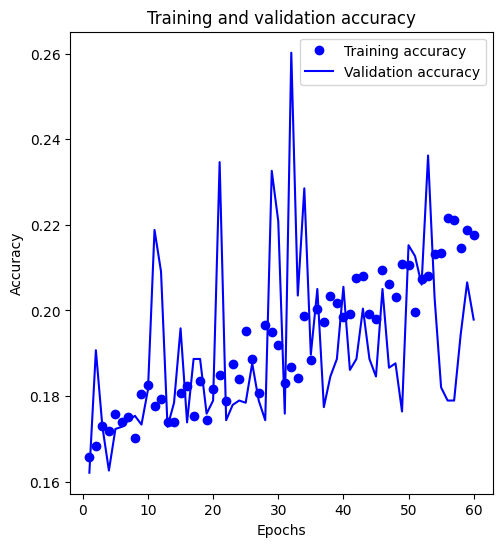

In [27]:
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

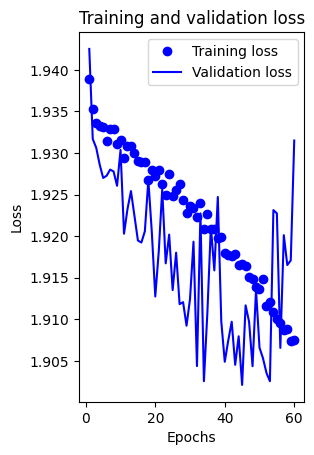

In [28]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

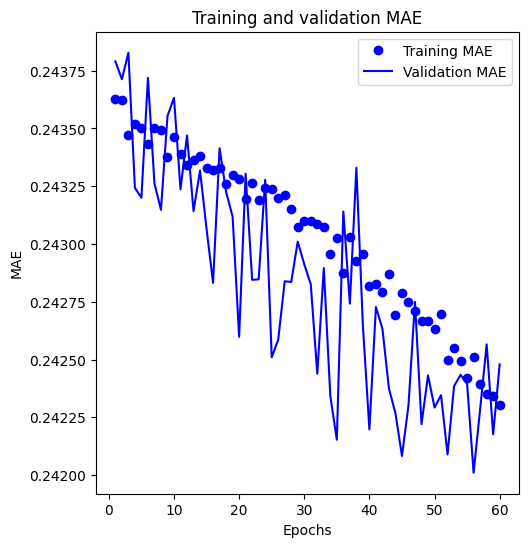

In [29]:
# Plot MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [ ]:
# Load the best model weights
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/tuned_D1_CNN1_A3.h5')

# Evaluate the model
test_loss, test_accuracy, test_mae = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test MAE: {test_mae:.2f}')